In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [4]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        dkl = - torch.log(self.data_rho) * rho - torch.log(1-self.data_rho) * (1-rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [18]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [19]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.955864 32: 0.948106 64: 0.956732
Train Epoch: 1 [12800/50000 (26%)]	Losses 16: 0.507571 32: 0.419571 64: 0.359906
Train Epoch: 1 [25600/50000 (51%)]	Losses 16: 0.326881 32: 0.307132 64: 0.295482
Train Epoch: 1 [38400/50000 (77%)]	Losses 16: 0.290416 32: 0.282486 64: 0.276205
Train Epoch: 1 [12512/50000 (100%)]	Losses 16: 0.243384 32: 0.237555 64: 0.233156
Test set:
16: loss: 0.2813	pho_loss: 0.0032
32: loss: 0.2770	pho_loss: 0.0033
64: loss: 0.2730	pho_loss: 0.0033

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.292312 32: 0.288262 64: 0.284145
Train Epoch: 2 [12800/50000 (26%)]	Losses 16: 0.283725 32: 0.280914 64: 0.278339
Train Epoch: 2 [25600/50000 (51%)]	Losses 16: 0.270020 32: 0.267240 64: 0.266165
Train Epoch: 2 [38400/50000 (77%)]	Losses 16: 0.270357 32: 0.266777 64: 0.267367
Train Epoch: 2 [12512/50000 (100%)]	Losses 16: 0.230018 32: 0.225207 64: 0.229105
Test set:
16: loss: 0.2616	pho_loss: 0.0031
32: loss: 0.2581	pho_loss: 0.0031
64: los

Train Epoch: 17 [12800/50000 (26%)]	Losses 16: 0.135853 32: 0.117434 64: 0.109805
Train Epoch: 17 [25600/50000 (51%)]	Losses 16: 0.137364 32: 0.116892 64: 0.111352
Train Epoch: 17 [38400/50000 (77%)]	Losses 16: 0.147314 32: 0.125167 64: 0.117112
Train Epoch: 17 [12512/50000 (100%)]	Losses 16: 0.162652 32: 0.139450 64: 0.131290
Test set:
16: loss: 0.1419	pho_loss: 0.0032
32: loss: 0.1199	pho_loss: 0.0032
64: loss: 0.1128	pho_loss: 0.0031

Train Epoch: 18 [0/50000 (0%)]	Losses 16: 0.140161 32: 0.119108 64: 0.112689
Train Epoch: 18 [12800/50000 (26%)]	Losses 16: 0.146971 32: 0.123730 64: 0.116544
Train Epoch: 18 [25600/50000 (51%)]	Losses 16: 0.132891 32: 0.111794 64: 0.105958
Train Epoch: 18 [38400/50000 (77%)]	Losses 16: 0.126605 32: 0.105735 64: 0.099215
Train Epoch: 18 [12512/50000 (100%)]	Losses 16: 0.118234 32: 0.098515 64: 0.096589
Test set:
16: loss: 0.1371	pho_loss: 0.0032
32: loss: 0.1159	pho_loss: 0.0032
64: loss: 0.1078	pho_loss: 0.0031

Train Epoch: 19 [0/50000 (0%)]	Losses 1

In [20]:
torch.save(models['64'], './model_64_kl_gn1')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [6]:
model = torch.load('./model_64_kl_gn1')

In [11]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
   
    print (encoded[0])

tensor([  7,   6,   3,   7,   5,   5,   2,   4,   3,   4,   5,   0,
          6,   6,   5,   3,   5,   4,   6,   3,   9,   8,   2,   4,
          3,   4,   8,   4,   6,   6,   4,   6,   8,   1,   5,   3,
          3,   5,   1,   6,   5,   4,   4,   1,   3,   4,   6,   3,
          5,   4,   4,   2,   5,   4,   3,   5,   4,   3,   6,   5,
         11,   1,   1,   2])
tensor([ 0.0000,  0.3024,  0.0000,  0.0000,  0.0000,  0.3008,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.2708,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.6527,  0.0000,  0.3037,  0.0000,  0.0000,  0.2141,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2087,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  

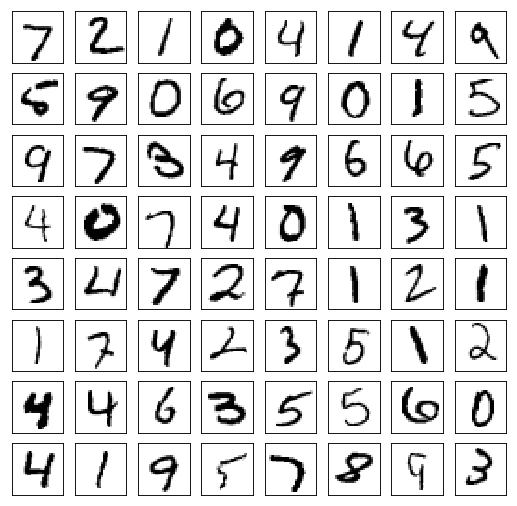

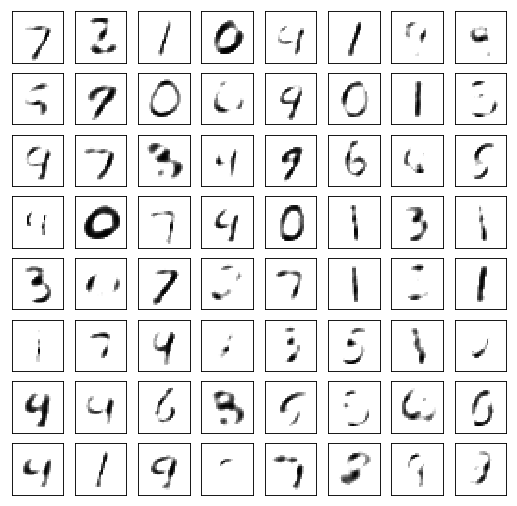

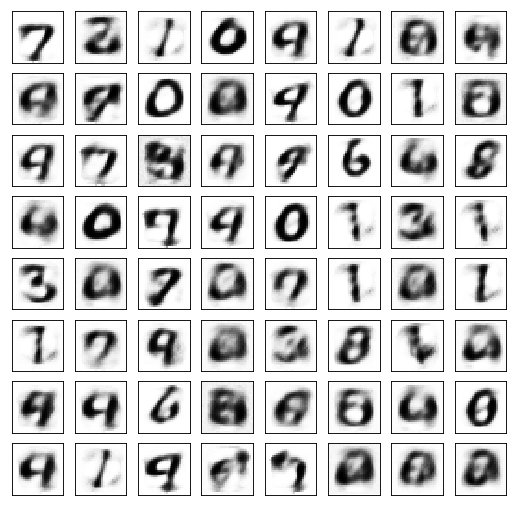

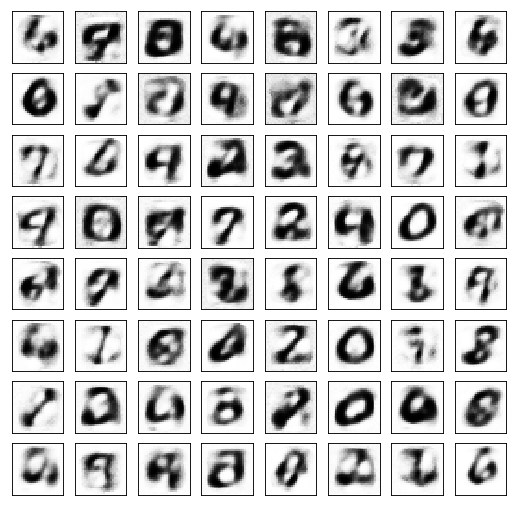

In [9]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [11]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(64)
    loss_stats = []
    
    gen_optim = optim.Adam([gen_img_par], lr=1e-3, weight_decay=0.)

    for i in range(1, 1000001):  
        
        target = model.E(gen_img_par.view(-1, 28*28))
        
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 2000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 40000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

### Генерация изображений из батча

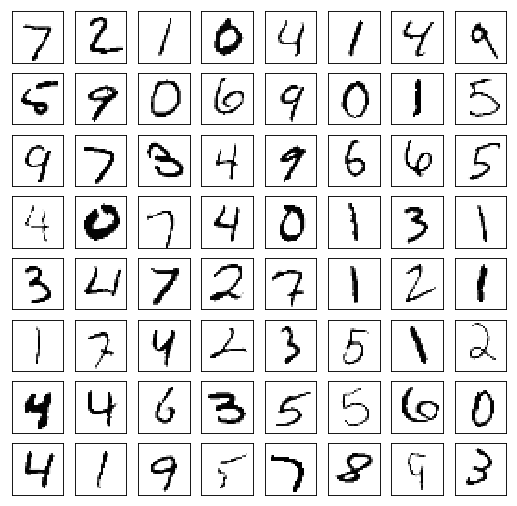

In [12]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.0018874993547797203
Iteration 4000: loss=0.0011395945912227035
Iteration 6000: loss=0.0009769154712557793
Iteration 8000: loss=0.0009073978872038424
Iteration 10000: loss=0.0008774112211540341
Iteration 12000: loss=0.0008595676044933498
Iteration 14000: loss=0.0008518212707713246
Iteration 16000: loss=0.0008475878858007491
Iteration 18000: loss=0.0008447415311820805
Iteration 20000: loss=0.0008431571768596768
Iteration 22000: loss=0.0008412694442085922
Iteration 24000: loss=0.0008405607659369707
Iteration 26000: loss=0.0008401646628044546
Iteration 28000: loss=0.000839738582726568
Iteration 30000: loss=0.0008382753003388643
Iteration 32000: loss=0.0008373270975425839
Iteration 34000: loss=0.000837072147987783
Iteration 36000: loss=0.0008359064231626689
Iteration 38000: loss=0.0008342142682522535
Iteration 40000: loss=0.0008340022177435458


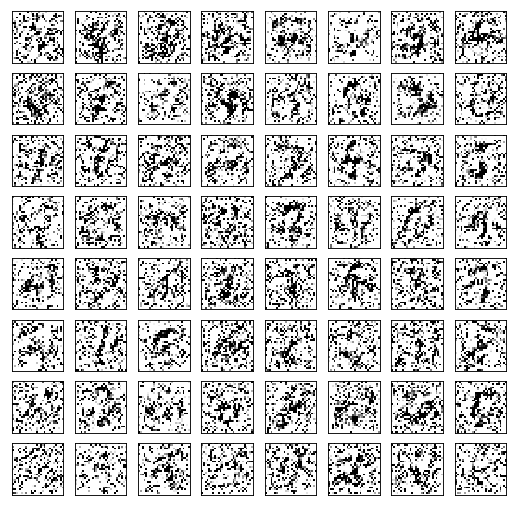

Iteration 42000: loss=0.0008337250910699368
Iteration 44000: loss=0.0008330971468240023
Iteration 46000: loss=0.0008329385309480131
Iteration 48000: loss=0.0008328038384206593
Iteration 50000: loss=0.0008327043033204973
Iteration 52000: loss=0.0008326285751536489
Iteration 54000: loss=0.000832230900414288
Iteration 56000: loss=0.0008320939959958196
Iteration 58000: loss=0.0008316733292303979
Iteration 60000: loss=0.0008314963197335601
Iteration 62000: loss=0.0008314417209476233
Iteration 64000: loss=0.0008311140118166804
Iteration 66000: loss=0.0008310637786053121
Iteration 68000: loss=0.0008310338598676026
Iteration 70000: loss=0.0008310064440593123
Iteration 72000: loss=0.0008309741970151663
Iteration 74000: loss=0.0008308786200359464
Iteration 76000: loss=0.0008308049873448908
Iteration 78000: loss=0.00083078135503456
Iteration 80000: loss=0.0008307585958391428


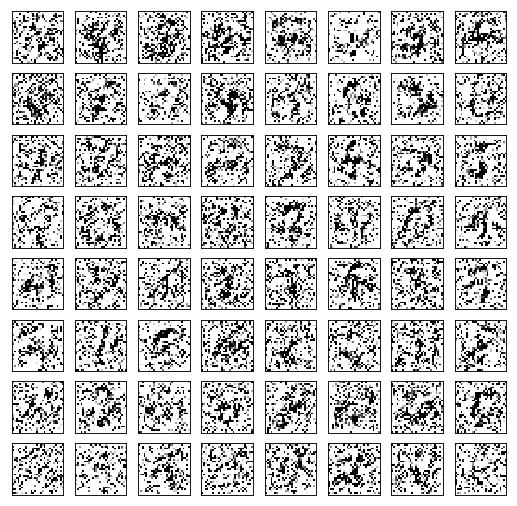

Iteration 82000: loss=0.0008307314710691571
Iteration 84000: loss=0.0008307021344080567
Iteration 86000: loss=0.0008306822855956852
Iteration 88000: loss=0.0008306673262268305
Iteration 90000: loss=0.0008306512027047575
Iteration 92000: loss=0.0008306367672048509
Iteration 94000: loss=0.000830625300295651
Iteration 96000: loss=0.0008306130766868591
Iteration 98000: loss=0.0008306020754389465
Iteration 100000: loss=0.0008305917726829648
Iteration 102000: loss=0.0008305799565277994
Iteration 104000: loss=0.0008305700030177832
Iteration 106000: loss=0.0008305619703605771
Iteration 108000: loss=0.0008305511437356472
Iteration 110000: loss=0.0008305385708808899
Iteration 112000: loss=0.000830527045764029
Iteration 114000: loss=0.0008305180235765874
Iteration 116000: loss=0.0008305104565806687
Iteration 118000: loss=0.0008305029477924109
Iteration 120000: loss=0.0008304956136271358


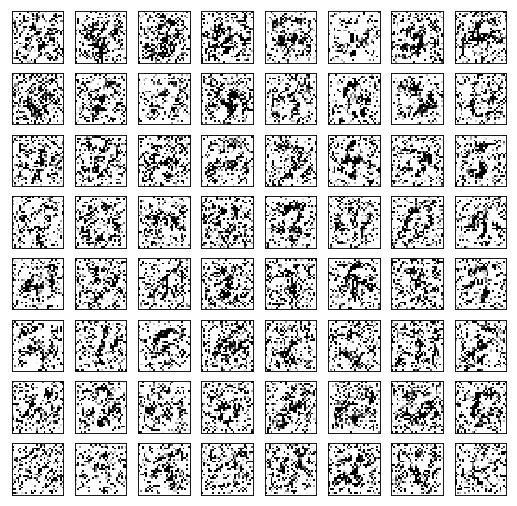

Iteration 122000: loss=0.0008304821676574647
Iteration 124000: loss=0.0008301677880808711
Iteration 126000: loss=0.0008301461930386722
Iteration 128000: loss=0.0008301346097141504
Iteration 130000: loss=0.0008301274501718581
Iteration 132000: loss=0.0008301222114823759
Iteration 134000: loss=0.0008301168563775718
Iteration 136000: loss=0.0008301119087263942
Iteration 138000: loss=0.0008301070774905384
Iteration 140000: loss=0.0008301017223857343
Iteration 142000: loss=0.000830097880680114
Iteration 144000: loss=0.0008300940971821547
Iteration 146000: loss=0.0008300901390612125
Iteration 148000: loss=0.0008300834451802075
Iteration 150000: loss=0.0008300550980493426
Iteration 152000: loss=0.0008297543390654027
Iteration 154000: loss=0.0008295528241433203
Iteration 156000: loss=0.0008295417646877468
Iteration 158000: loss=0.0008295350708067417
Iteration 160000: loss=0.0008295312873087823


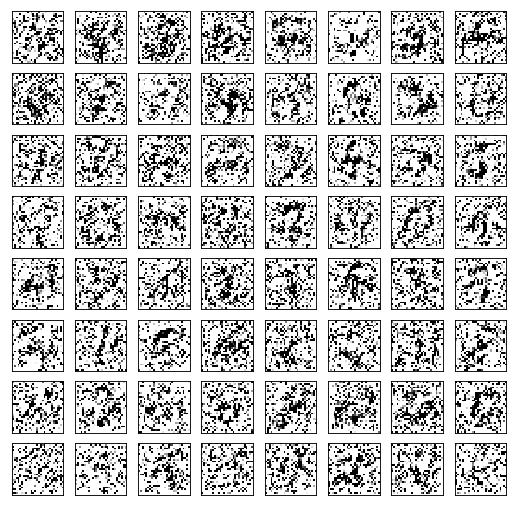

Iteration 162000: loss=0.0008295272127725184
Iteration 164000: loss=0.0008295227307826281
Iteration 166000: loss=0.0008295192965306342
Iteration 168000: loss=0.0008295156294479966
Iteration 170000: loss=0.0008295110310427845
Iteration 172000: loss=0.0008295067236758769
Iteration 174000: loss=0.0008294907747767866
Iteration 176000: loss=0.0008294849540106952
Iteration 178000: loss=0.0008294818107970059
Iteration 180000: loss=0.0008294781437143683
Iteration 182000: loss=0.0008294744766317308
Iteration 184000: loss=0.0008294714498333633
Iteration 186000: loss=0.0008294684812426567
Iteration 188000: loss=0.0008294633589684963
Iteration 190000: loss=0.0008294281433336437
Iteration 192000: loss=0.0008294038707390428
Iteration 194000: loss=0.0008294002036564052
Iteration 196000: loss=0.0008293971186503768
Iteration 198000: loss=0.0008293946739286184
Iteration 200000: loss=0.0008293926948681474


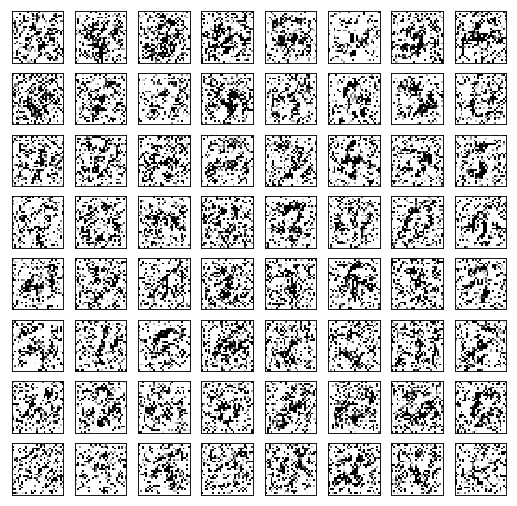

Iteration 202000: loss=0.0008293905411846936
Iteration 204000: loss=0.0008293885621242225
Iteration 206000: loss=0.0008293856517411768
Iteration 208000: loss=0.000829384895041585
Iteration 210000: loss=0.0008293823339045048
Iteration 212000: loss=0.0008293786086142063
Iteration 214000: loss=0.0008293697610497475
Iteration 216000: loss=0.0008293597493320704
Iteration 218000: loss=0.0008293574210256338
Iteration 220000: loss=0.0008293550345115364
Iteration 222000: loss=0.000829350552521646
Iteration 224000: loss=0.0008293475839309394
Iteration 226000: loss=0.0008293461869470775
Iteration 228000: loss=0.0008293445571325719
Iteration 230000: loss=0.0008293426944874227
Iteration 232000: loss=0.0008293413557112217
Iteration 234000: loss=0.0008293393766507506
Iteration 236000: loss=0.0008293379796668887
Iteration 238000: loss=0.0008293344872072339
Iteration 240000: loss=0.0008293277933262289


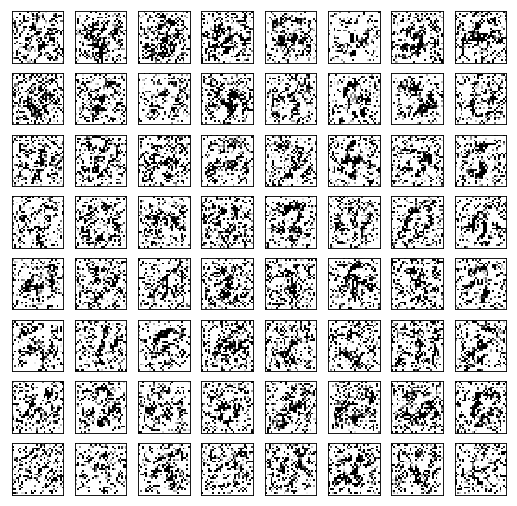

Iteration 242000: loss=0.0008292749407701194
Iteration 244000: loss=0.0008292653947137296
Iteration 246000: loss=0.0008292562561109662
Iteration 248000: loss=0.0008287291857413948
Iteration 250000: loss=0.0008287129458039999
Iteration 252000: loss=0.0008287082309834659
Iteration 254000: loss=0.0008287049131467938
Iteration 256000: loss=0.0008287003729492426
Iteration 258000: loss=0.0008286937372758985
Iteration 260000: loss=0.000828685937449336
Iteration 262000: loss=0.0008286632364615798
Iteration 264000: loss=0.0008286559605039656
Iteration 266000: loss=0.000828652991913259
Iteration 268000: loss=0.0008286510710604489
Iteration 270000: loss=0.0008286493830382824
Iteration 272000: loss=0.0008286481024697423
Iteration 274000: loss=0.0008286467636935413
Iteration 276000: loss=0.0008286455413326621
Iteration 278000: loss=0.0008286440861411393
Iteration 280000: loss=0.0008286428055725992


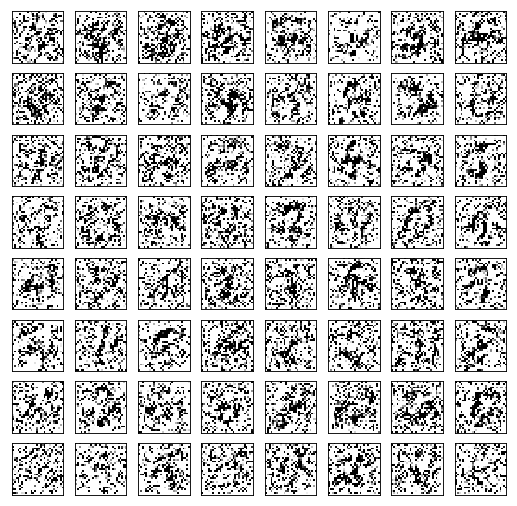

Iteration 282000: loss=0.00082864158321172
Iteration 284000: loss=0.0008286410593427718
Iteration 286000: loss=0.0008286403608508408
Iteration 288000: loss=0.0008286393131129444
Iteration 290000: loss=0.0008286380325444043
Iteration 292000: loss=0.0008286367519758642
Iteration 294000: loss=0.0008286358788609505
Iteration 296000: loss=0.0008286350057460368
Iteration 298000: loss=0.000828633492346853
Iteration 300000: loss=0.0008286325610242784
Iteration 302000: loss=0.0008286323864012957
Iteration 304000: loss=0.0008286311640404165
Iteration 306000: loss=0.0008286310476250947
Iteration 308000: loss=0.0008286297670565546
Iteration 310000: loss=0.0008286293013952672
Iteration 312000: loss=0.0008286284282803535
Iteration 314000: loss=0.0008286273223347962
Iteration 316000: loss=0.0008286263910122216
Iteration 318000: loss=0.0008286255178973079
Iteration 320000: loss=0.0008286250522360206


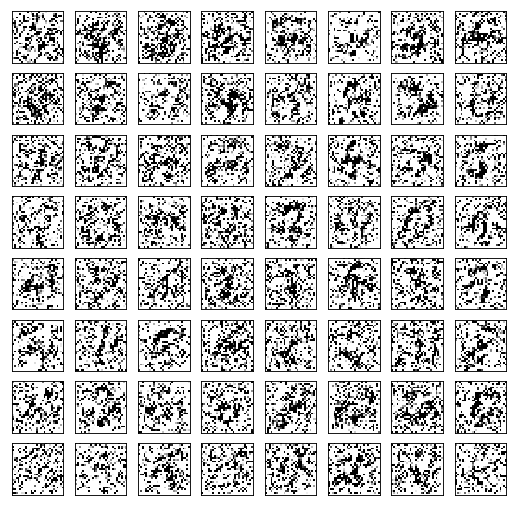

Iteration 322000: loss=0.0008286245865747333
Iteration 324000: loss=0.0008286239462904632
Iteration 326000: loss=0.0008286233060061932
Iteration 328000: loss=0.0008286223746836185
Iteration 330000: loss=0.000828621385153383
Iteration 332000: loss=0.0008286206866614521
Iteration 334000: loss=0.0008286196971312165
Iteration 336000: loss=0.0008286188822239637
Iteration 338000: loss=0.0008286182419396937
Iteration 340000: loss=0.0008286172524094582
Iteration 342000: loss=0.0008286167867481709
Iteration 344000: loss=0.0008286160882562399
Iteration 346000: loss=0.0008286150987260044
Iteration 348000: loss=0.0008286147494800389
Iteration 350000: loss=0.0008286137599498034
Iteration 352000: loss=0.0008286130614578724
Iteration 354000: loss=0.0008286128286272287
Iteration 356000: loss=0.0008286121301352978
Iteration 358000: loss=0.0008286111988127232
Iteration 360000: loss=0.0008286107331514359


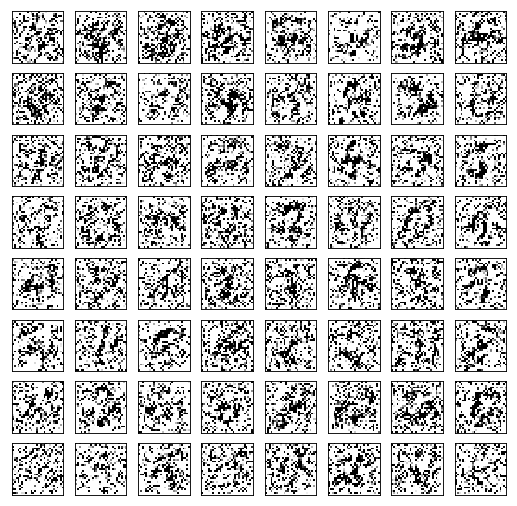

Iteration 362000: loss=0.000828610616736114
Iteration 364000: loss=0.0008286098600365222
Iteration 366000: loss=0.0008286089287139475
Iteration 368000: loss=0.0008286084048449993
Iteration 370000: loss=0.000828607298899442
Iteration 372000: loss=0.0008286068914458156
Iteration 374000: loss=0.0008286065421998501
Iteration 376000: loss=0.0008286057272925973
Iteration 378000: loss=0.0008286050870083272
Iteration 380000: loss=0.000828604563139379
Iteration 382000: loss=0.0008286040974780917
Iteration 384000: loss=0.0008286036900244653
Iteration 386000: loss=0.0008286032825708389
Iteration 388000: loss=0.0008286026422865689
Iteration 390000: loss=0.0008286015363410115
Iteration 392000: loss=0.000828601245302707
Iteration 394000: loss=0.0008286008960567415
Iteration 396000: loss=0.0008286000229418278
Iteration 398000: loss=0.0008285990916192532
Iteration 400000: loss=0.0008285985677503049


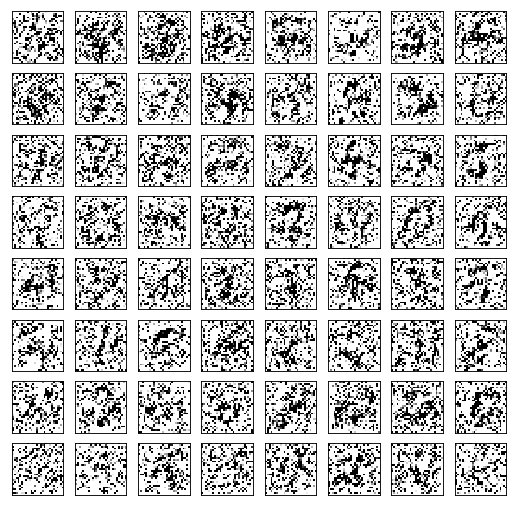

Iteration 402000: loss=0.0008285981602966785
Iteration 404000: loss=0.0008285963558591902
Iteration 406000: loss=0.0008285952499136329
Iteration 408000: loss=0.0008285943185910583
Iteration 410000: loss=0.00082859315443784
Iteration 412000: loss=0.0008285930962301791
Iteration 414000: loss=0.0008285919902846217
Iteration 416000: loss=0.0008285913500003517
Iteration 418000: loss=0.0008285903022624552
Iteration 420000: loss=0.0008285886724479496
Iteration 422000: loss=0.0008285362273454666
Iteration 424000: loss=0.0008284872164949775
Iteration 426000: loss=0.0008284844225272536
Iteration 428000: loss=0.0008284829091280699
Iteration 430000: loss=0.0008284802897833288
Iteration 432000: loss=0.0008284719078801572
Iteration 434000: loss=0.0008284687646664679
Iteration 436000: loss=0.0008284681243821979
Iteration 438000: loss=0.0008284676587209105
Iteration 440000: loss=0.0008284668438136578


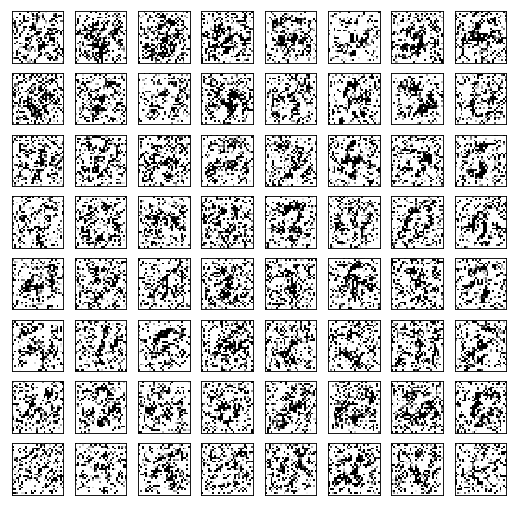

Iteration 442000: loss=0.0008284659706987441
Iteration 444000: loss=0.0008284659706987441
Iteration 446000: loss=0.0008284656214527786
Iteration 448000: loss=0.0008284649811685085
Iteration 450000: loss=0.0008284640498459339
Iteration 452000: loss=0.0008284642826765776
Iteration 454000: loss=0.000828463991638273
Iteration 456000: loss=0.0008284632349386811
Iteration 458000: loss=0.0008284627110697329
Iteration 460000: loss=0.0008284623618237674
Iteration 462000: loss=0.0008284618961624801
Iteration 464000: loss=0.0008284617215394974
Iteration 466000: loss=0.0008284616051241755
Iteration 468000: loss=0.0008284613722935319
Iteration 470000: loss=0.00082846061559394
Iteration 472000: loss=0.0008284603245556355
Iteration 474000: loss=0.0008284597424790263
Iteration 476000: loss=0.0008284596260637045
Iteration 478000: loss=0.0008284591021947563
Iteration 480000: loss=0.0008284589857794344


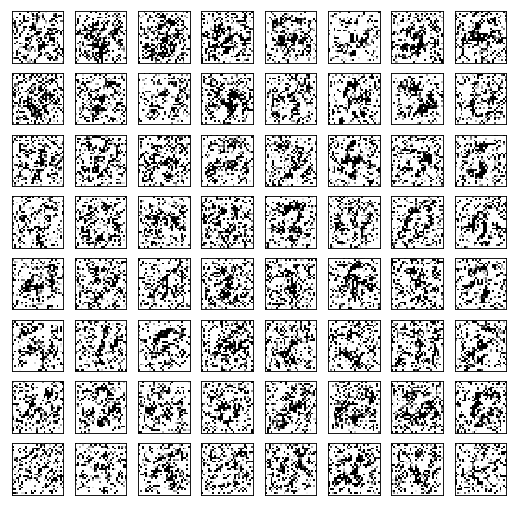

Iteration 482000: loss=0.000828458636533469
Iteration 484000: loss=0.0008284584037028253
Iteration 486000: loss=0.0008284582872875035
Iteration 488000: loss=0.0008284580544568598
Iteration 490000: loss=0.0008284574141725898
Iteration 492000: loss=0.0008284577634185553
Iteration 494000: loss=0.000828457239549607
Iteration 496000: loss=0.000828457239549607
Iteration 498000: loss=0.0008284565410576761
Iteration 500000: loss=0.0008284564828500152
Iteration 502000: loss=0.0008284558425657451
Iteration 504000: loss=0.0008284555515274405
Iteration 506000: loss=0.0008284554933197796
Iteration 508000: loss=0.0008284549694508314
Iteration 510000: loss=0.0008284547366201878
Iteration 512000: loss=0.0008284546784125268
Iteration 514000: loss=0.0008284542709589005
Iteration 516000: loss=0.0008284542127512395
Iteration 518000: loss=0.0008284534560516477
Iteration 520000: loss=0.0008284533396363258


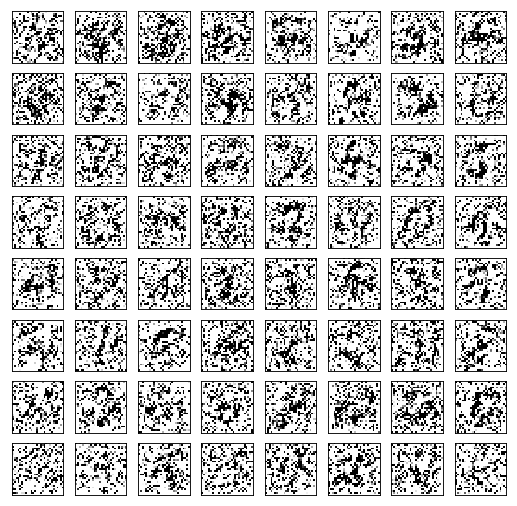

Iteration 522000: loss=0.0008284530485980213
Iteration 524000: loss=0.0008284527575597167
Iteration 526000: loss=0.0008284521172754467
Iteration 528000: loss=0.0008284522918984294
Iteration 530000: loss=0.0008284520008601248
Iteration 532000: loss=0.0008284514769911766
Iteration 534000: loss=0.0008284514769911766
Iteration 536000: loss=0.0008284513023681939
Iteration 538000: loss=0.0008284510113298893
Iteration 540000: loss=0.000828450545668602
Iteration 542000: loss=0.0008284503128379583
Iteration 544000: loss=0.0008284500800073147
Iteration 546000: loss=0.0008284500217996538
Iteration 548000: loss=0.0008284496143460274
Iteration 550000: loss=0.0008284493815153837
Iteration 552000: loss=0.0008284490904770792
Iteration 554000: loss=0.0008284486830234528
Iteration 556000: loss=0.0008284482173621655
Iteration 558000: loss=0.0008284479845315218
Iteration 560000: loss=0.0008284478681162


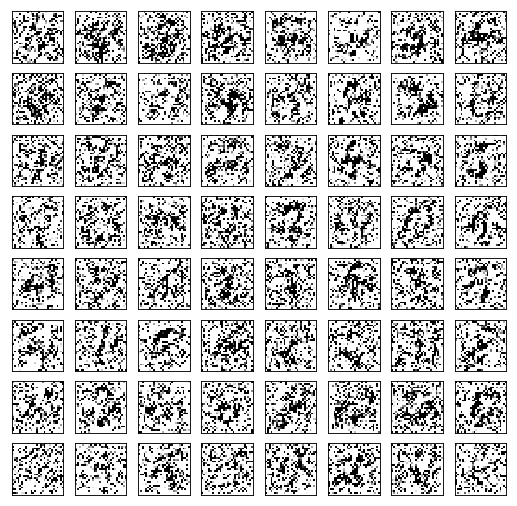

Iteration 562000: loss=0.0008284475770778954
Iteration 564000: loss=0.0008284472860395908
Iteration 566000: loss=0.0008284469950012863
Iteration 568000: loss=0.000828446529339999
Iteration 570000: loss=0.0008284462383016944
Iteration 572000: loss=0.0008284459472633898
Iteration 574000: loss=0.0008284460054710507
Iteration 576000: loss=0.0008284455980174243
Iteration 578000: loss=0.0008284452487714589
Iteration 580000: loss=0.0008284447249025106
Iteration 582000: loss=0.0008284448995254934
Iteration 584000: loss=0.0008284448413178325
Iteration 586000: loss=0.0008284448995254934
Iteration 588000: loss=0.000828444492071867
Iteration 590000: loss=0.0008284442592412233
Iteration 592000: loss=0.0008284439099952579
Iteration 594000: loss=0.0008284435607492924
Iteration 596000: loss=0.0008284430950880051
Iteration 598000: loss=0.0008284426876343787
Iteration 600000: loss=0.0008284420473501086


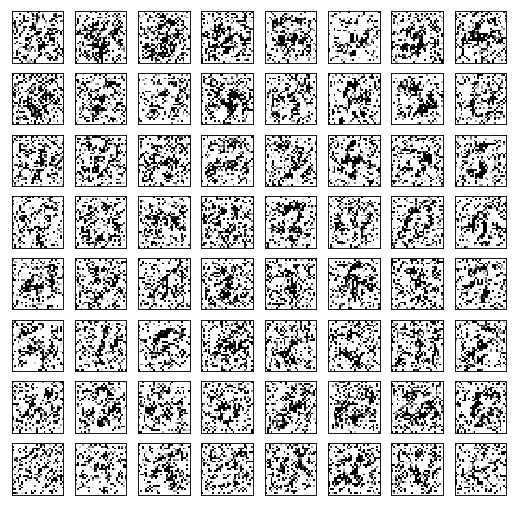

Iteration 602000: loss=0.000828441814519465
Iteration 604000: loss=0.0008284408249892294
Iteration 606000: loss=0.0008284395444206893
Iteration 608000: loss=0.0008284385548904538
Iteration 610000: loss=0.0008284383220598102
Iteration 612000: loss=0.0008284383802674711
Iteration 614000: loss=0.0008284379146061838
Iteration 616000: loss=0.0008284376235678792
Iteration 618000: loss=0.0008284375071525574
Iteration 620000: loss=0.0008284374489448965
Iteration 622000: loss=0.0008284371579065919
Iteration 624000: loss=0.0008284363429993391
Iteration 626000: loss=0.0008284364594146609
Iteration 628000: loss=0.0008284365758299828
Loss is rising .. stop


In [13]:
new_image_batch = generate_image(img)

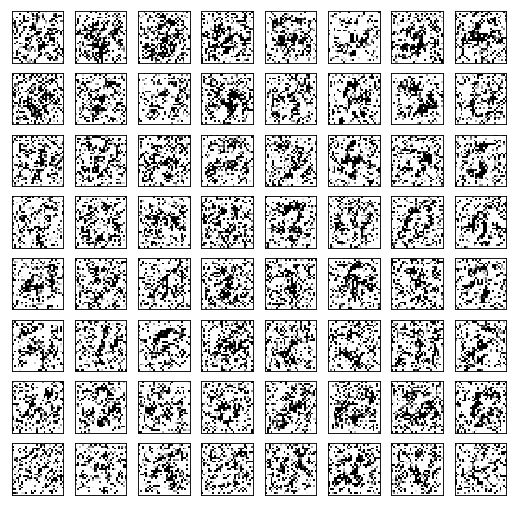

In [14]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [15]:
latent = model.E(new_image_batch.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 0.8630,  0.0034,  0.0131,  ...,  0.0025,  0.0253,  0.0191],
        [ 0.0049,  0.9331,  0.0218,  ...,  0.0035,  0.0031,  0.0007],
        [ 0.0023,  0.0406,  0.8975,  ...,  0.0022,  0.0013,  0.0008],
        ...,
        [ 0.0039,  0.0094,  0.0067,  ...,  0.8556,  0.0163,  0.0019],
        [ 0.0182,  0.0065,  0.0042,  ...,  0.0242,  0.8592,  0.0021],
        [ 0.0428,  0.0054,  0.0050,  ...,  0.0065,  0.0040,  0.8595]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


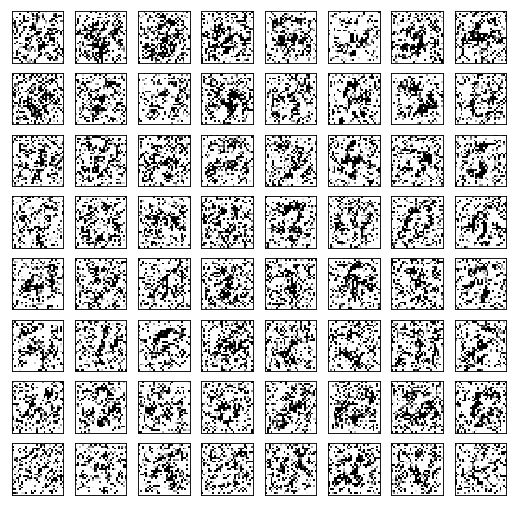

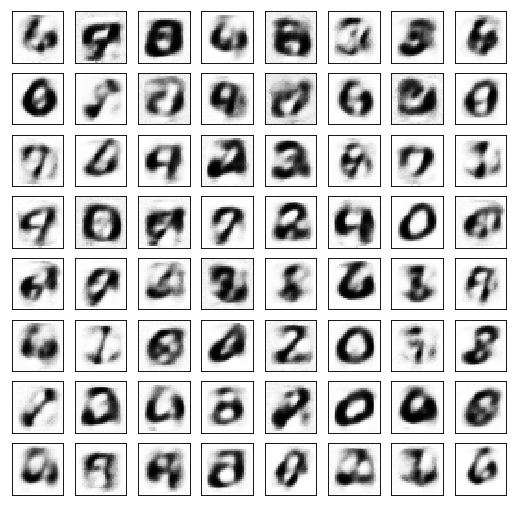

In [16]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_batch.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))    

### Генерация изображений из случайного шума

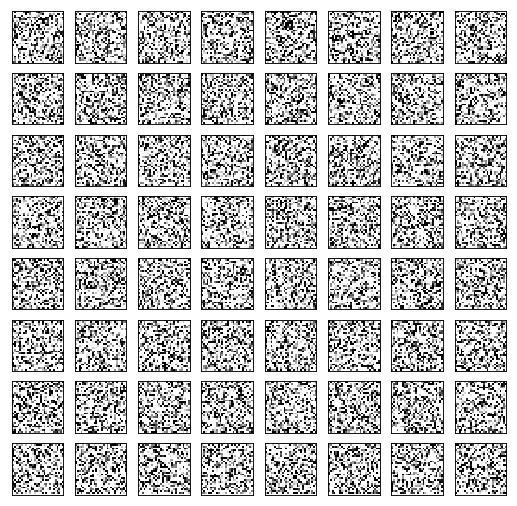

In [17]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.005011526867747307
Iteration 4000: loss=0.002365252235904336
Iteration 6000: loss=0.001542756101116538
Iteration 8000: loss=0.0011745489900931716
Iteration 10000: loss=0.0009971392573788762
Iteration 12000: loss=0.000912874354980886
Iteration 14000: loss=0.0008705048821866512
Iteration 16000: loss=0.000849036208819598
Iteration 18000: loss=0.0008373779710382223
Iteration 20000: loss=0.0008314628503285348
Iteration 22000: loss=0.0008281042682938278
Iteration 24000: loss=0.0008267017547041178
Iteration 26000: loss=0.0008254816639237106
Iteration 28000: loss=0.000824270595330745
Iteration 30000: loss=0.000823770766146481
Iteration 32000: loss=0.0008219942101277411
Iteration 34000: loss=0.0008202344179153442
Iteration 36000: loss=0.0008194888941943645
Iteration 38000: loss=0.0008191574015654624
Iteration 40000: loss=0.0008189185755327344


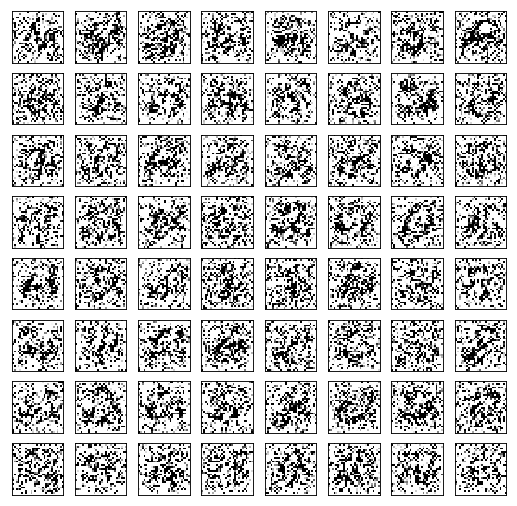

Iteration 42000: loss=0.0008187823696061969
Iteration 44000: loss=0.0008186756167560816
Iteration 46000: loss=0.0008180670556612313
Iteration 48000: loss=0.0008179611177183688
Iteration 50000: loss=0.000817873515188694
Iteration 52000: loss=0.0008176990086212754
Iteration 54000: loss=0.0008174392278306186
Iteration 56000: loss=0.0008173479000106454
Iteration 58000: loss=0.0008172864909283817
Iteration 60000: loss=0.0008167288033291698
Iteration 62000: loss=0.0008166790357790887
Iteration 64000: loss=0.0008166377083398402
Iteration 66000: loss=0.0008166030747815967
Iteration 68000: loss=0.0008165606413967907
Iteration 70000: loss=0.000816169660538435
Iteration 72000: loss=0.000816104409750551
Iteration 74000: loss=0.0008160737925209105
Iteration 76000: loss=0.0008160479483194649
Iteration 78000: loss=0.0008160213474184275
Iteration 80000: loss=0.0008159783319570124


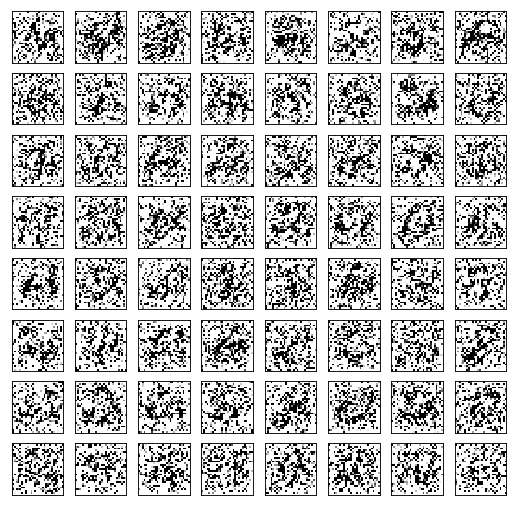

Iteration 82000: loss=0.0008158694254234433
Iteration 84000: loss=0.0008158249547705054
Iteration 86000: loss=0.0008157964912243187
Iteration 88000: loss=0.0008157729753293097
Iteration 90000: loss=0.0008157463744282722
Iteration 92000: loss=0.0008155907853506505
Iteration 94000: loss=0.0008155609830282629
Iteration 96000: loss=0.0008155214018188417
Iteration 98000: loss=0.0008155022514984012
Iteration 100000: loss=0.0008154556853696704
Iteration 102000: loss=0.0008154211682267487
Iteration 104000: loss=0.0008153714006766677
Iteration 106000: loss=0.000815270293969661
Iteration 108000: loss=0.0008152520749717951
Iteration 110000: loss=0.0008152416558004916
Iteration 112000: loss=0.0008152316440828145
Iteration 114000: loss=0.0008152229129336774
Iteration 116000: loss=0.000815215811599046
Iteration 118000: loss=0.0008152071386575699
Iteration 120000: loss=0.0008151990477927029


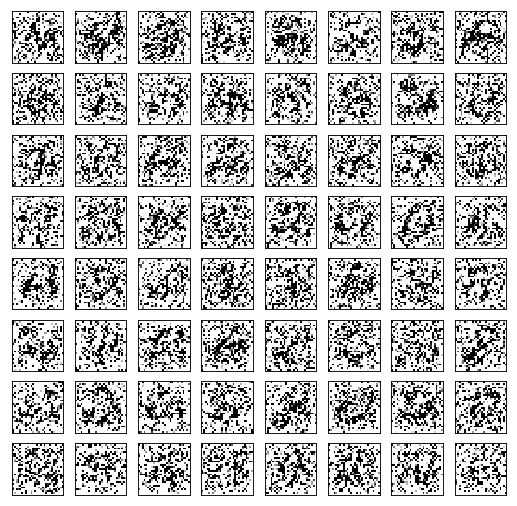

Iteration 122000: loss=0.0008151924703270197
Iteration 124000: loss=0.0008151846705004573
Iteration 126000: loss=0.0008151712827384472
Iteration 128000: loss=0.0008150874637067318
Iteration 130000: loss=0.0008150747162289917
Iteration 132000: loss=0.0008148891502059996
Iteration 134000: loss=0.0008148397319018841
Iteration 136000: loss=0.0008148290798999369
Iteration 138000: loss=0.0008148206397891045
Iteration 140000: loss=0.0008148130145855248
Iteration 142000: loss=0.0008147968328557909
Iteration 144000: loss=0.0008144444436766207
Iteration 146000: loss=0.0008144279127009213
Iteration 148000: loss=0.0008143847226165235
Iteration 150000: loss=0.000814375642221421
Iteration 152000: loss=0.0008143692393787205
Iteration 154000: loss=0.0008143638260662556
Iteration 156000: loss=0.0008143580635078251
Iteration 158000: loss=0.0008143518352881074
Iteration 160000: loss=0.0008143463637679815


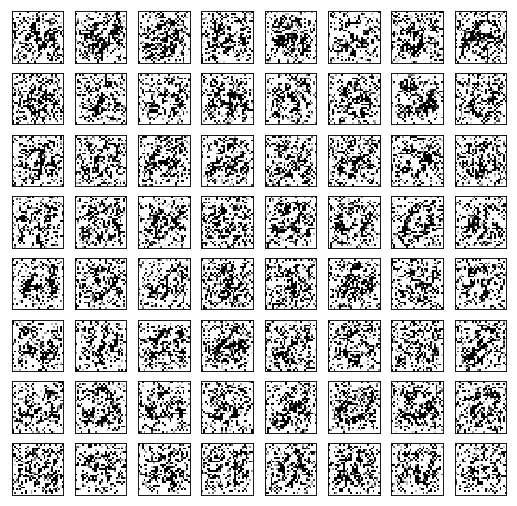

Iteration 162000: loss=0.0008143423474393785
Iteration 164000: loss=0.0008143379236571491
Iteration 166000: loss=0.0008143330924212933
Iteration 168000: loss=0.0008143297163769603
Iteration 170000: loss=0.00081432587467134
Iteration 172000: loss=0.0008143225568346679
Iteration 174000: loss=0.0008143206359818578
Iteration 176000: loss=0.0008143179002217948
Iteration 178000: loss=0.000814314465969801
Iteration 180000: loss=0.0008143119630403817
Iteration 182000: loss=0.0008143086452037096
Iteration 184000: loss=0.0008143061422742903
Iteration 186000: loss=0.0008143027662299573
Iteration 188000: loss=0.0008143006125465035
Iteration 190000: loss=0.0008142978185787797
Iteration 192000: loss=0.0008142946171574295
Iteration 194000: loss=0.0008142921142280102
Iteration 196000: loss=0.0008142885053530335
Iteration 198000: loss=0.0008142846054397523
Iteration 200000: loss=0.0008142663864418864


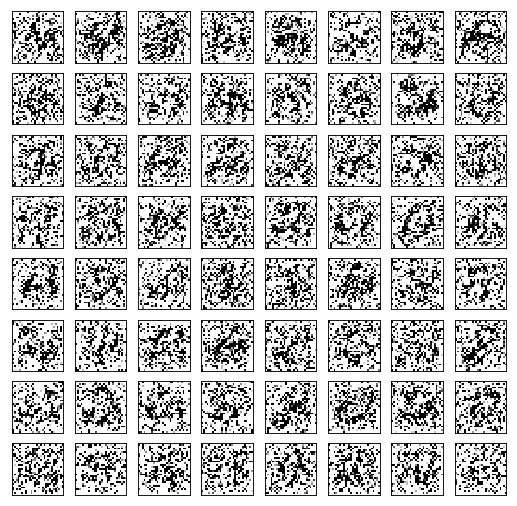

Iteration 202000: loss=0.0008142571896314621
Iteration 204000: loss=0.000814254570286721
Iteration 206000: loss=0.0008142513106577098
Iteration 208000: loss=0.000814249215181917
Iteration 210000: loss=0.0008142472361214459
Iteration 212000: loss=0.0008142453734762967
Iteration 214000: loss=0.0008142428705468774
Iteration 216000: loss=0.0008142403094097972
Iteration 218000: loss=0.0008142382721416652
Iteration 220000: loss=0.0008142351871356368
Iteration 222000: loss=0.0008142301812767982
Iteration 224000: loss=0.0008142272708937526
Iteration 226000: loss=0.0008142251172102988
Iteration 228000: loss=0.0008142228471115232
Iteration 230000: loss=0.0008142185979522765
Iteration 232000: loss=0.0008142148144543171
Iteration 234000: loss=0.0008142130682244897
Iteration 236000: loss=0.0008142115548253059
Iteration 238000: loss=0.0008142100996337831
Iteration 240000: loss=0.0008142090518958867


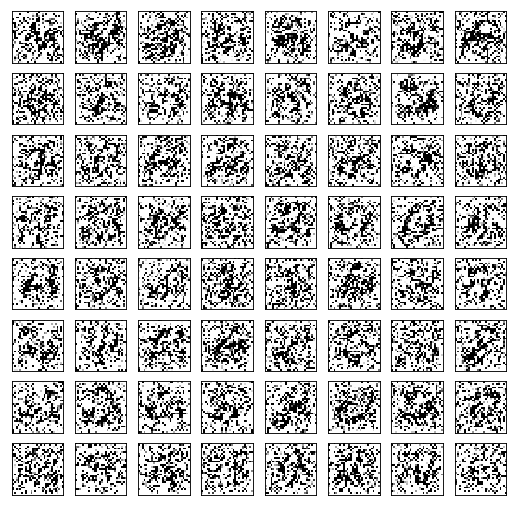

Iteration 242000: loss=0.0008142069564200938
Iteration 244000: loss=0.0008142058504745364
Iteration 246000: loss=0.0008142046863213181
Iteration 248000: loss=0.0008142030565068126
Iteration 250000: loss=0.0008142018341459334
Iteration 252000: loss=0.000814200786408037
Iteration 254000: loss=0.0008141989819705486
Iteration 256000: loss=0.0008141975267790258
Iteration 258000: loss=0.0008141955477185547
Iteration 260000: loss=0.0008141937432810664
Iteration 262000: loss=0.0008141922298818827
Iteration 264000: loss=0.0008141907746903598
Iteration 266000: loss=0.000814189319498837
Iteration 268000: loss=0.0008141882135532796
Iteration 270000: loss=0.0008141864091157913
Iteration 272000: loss=0.0008141858270391822
Iteration 274000: loss=0.0008141851867549121
Iteration 276000: loss=0.0008141844300553203
Iteration 278000: loss=0.0008141831494867802
Iteration 280000: loss=0.0008141824509948492


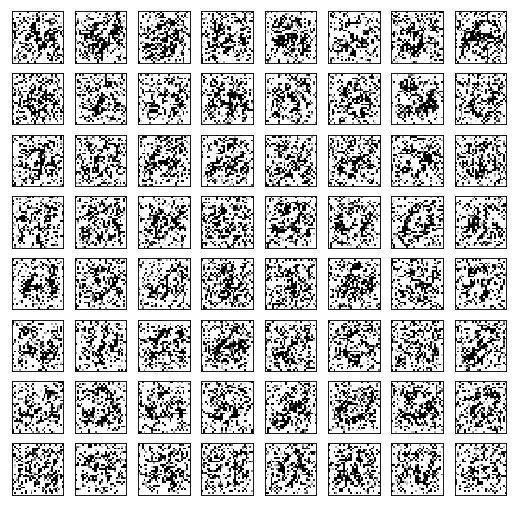

Iteration 282000: loss=0.0008141816360875964
Iteration 284000: loss=0.0008141806465573609
Iteration 286000: loss=0.0008141797734424472
Iteration 288000: loss=0.0008141783764585853
Iteration 290000: loss=0.0008141773869283497
Iteration 292000: loss=0.0008141768048517406
Iteration 294000: loss=0.0008141754660755396
Iteration 296000: loss=0.0008141744183376431
Iteration 298000: loss=0.0008141733705997467
Iteration 300000: loss=0.0008141723810695112
Iteration 302000: loss=0.000814171798992902
Iteration 304000: loss=0.0008141709258779883
Iteration 306000: loss=0.0008141708094626665
Iteration 308000: loss=0.0008141696453094482
Iteration 310000: loss=0.0008141688886098564
Iteration 312000: loss=0.0008141685393638909
Iteration 314000: loss=0.0008141672587953508
Iteration 316000: loss=0.0008141666185110807
Iteration 318000: loss=0.0008141655125655234
Iteration 320000: loss=0.0008141645812429488


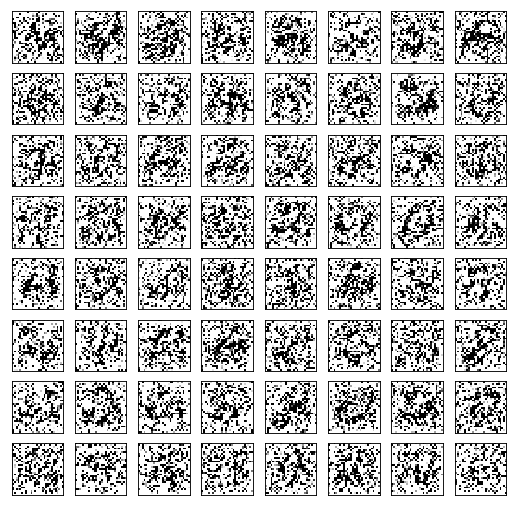

Iteration 322000: loss=0.0008141638827510178
Iteration 324000: loss=0.0008141629514284432
Iteration 326000: loss=0.0008141622529365122
Iteration 328000: loss=0.0008141607395373285
Iteration 330000: loss=0.0008141602156683803
Iteration 332000: loss=0.0008141599246300757
Iteration 334000: loss=0.0008141595753841102
Iteration 336000: loss=0.0008141587022691965
Iteration 338000: loss=0.0008141579455696046
Iteration 340000: loss=0.0008141568978317082
Iteration 342000: loss=0.0008141560829244554
Iteration 344000: loss=0.0008141555590555072
Iteration 346000: loss=0.0008141548605635762
Iteration 348000: loss=0.0008141543949022889
Iteration 350000: loss=0.0008141537546180189
Iteration 352000: loss=0.0008141531725414097
Iteration 354000: loss=0.0008141523576341569
Iteration 356000: loss=0.0008141520665958524
Iteration 358000: loss=0.0008141510770656168
Iteration 360000: loss=0.0008141509024426341


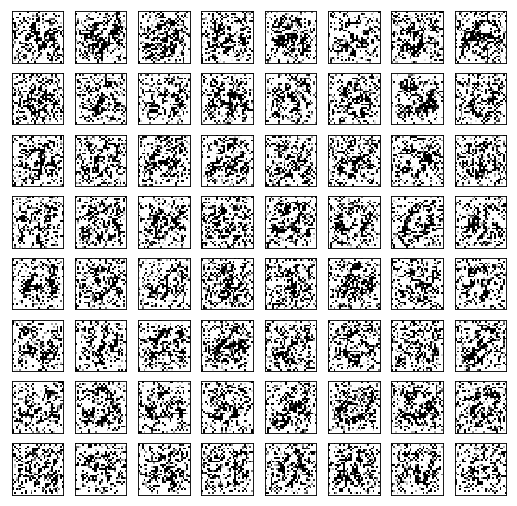

Iteration 362000: loss=0.0008141503785736859
Iteration 364000: loss=0.0008141498547047377
Iteration 366000: loss=0.0008141490980051458
Iteration 368000: loss=0.000814148981589824
Iteration 370000: loss=0.0008141483995132148
Iteration 372000: loss=0.000814147584605962
Iteration 374000: loss=0.000814146944321692
Iteration 376000: loss=0.0008141465368680656
Iteration 378000: loss=0.0008141452562995255
Iteration 380000: loss=0.0008141442085616291
Iteration 382000: loss=0.0008141421130858362
Iteration 384000: loss=0.0008141291909851134
Iteration 386000: loss=0.0008141135331243277
Iteration 388000: loss=0.0008140202844515443
Iteration 390000: loss=0.0008140064310282469
Iteration 392000: loss=0.0008140032878145576
Iteration 394000: loss=0.000814001658000052
Iteration 396000: loss=0.0008140006102621555
Iteration 398000: loss=0.0008139995043165982
Iteration 400000: loss=0.0008139981655403972


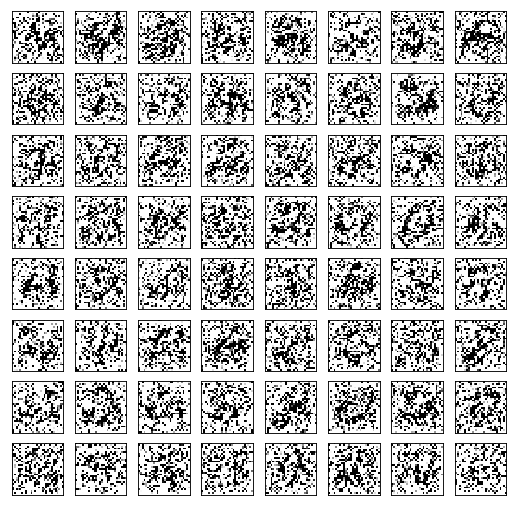

Iteration 402000: loss=0.0008139953715726733
Iteration 404000: loss=0.0008139933925122023
Iteration 406000: loss=0.0008139926940202713
Iteration 408000: loss=0.000813992228358984
Iteration 410000: loss=0.0008139919373206794
Iteration 412000: loss=0.0008139907731674612
Iteration 414000: loss=0.0008139902492985129
Iteration 416000: loss=0.0008139899582602084
Iteration 418000: loss=0.0008139893179759383
Iteration 420000: loss=0.0008139889687299728
Iteration 422000: loss=0.0008139883284457028
Iteration 424000: loss=0.000813988212030381
Iteration 426000: loss=0.0008139878045767546
Iteration 428000: loss=0.0008139876881614327
Iteration 430000: loss=0.0008139866404235363
Iteration 432000: loss=0.0008139863493852317
Iteration 434000: loss=0.0008139860001392663
Iteration 436000: loss=0.0008139859419316053
Iteration 438000: loss=0.0008139854180626571
Iteration 440000: loss=0.0008139846613630652


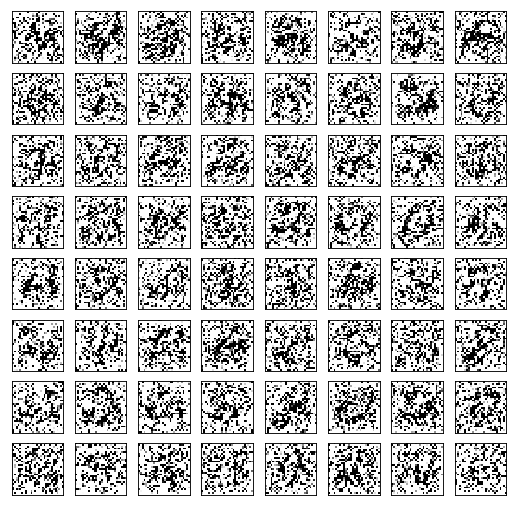

Iteration 442000: loss=0.0008139844285324216
Iteration 444000: loss=0.0008139839046634734
Iteration 446000: loss=0.0008139833807945251
Iteration 448000: loss=0.0008139829733408988
Iteration 450000: loss=0.0008139824494719505
Iteration 452000: loss=0.0008139819838106632
Iteration 454000: loss=0.0008139819838106632
Iteration 456000: loss=0.0008139815181493759
Iteration 458000: loss=0.0008139812271110713
Iteration 460000: loss=0.0008139806450344622
Iteration 462000: loss=0.000813980121165514
Iteration 464000: loss=0.0008139793062582612
Iteration 466000: loss=0.0008139789570122957
Iteration 468000: loss=0.0008139785495586693
Iteration 470000: loss=0.0008139780256897211
Iteration 472000: loss=0.0008139773271977901
Iteration 474000: loss=0.0008139771525748074
Iteration 476000: loss=0.0008139766287058592
Iteration 478000: loss=0.00081397604662925
Iteration 480000: loss=0.0008139759302139282


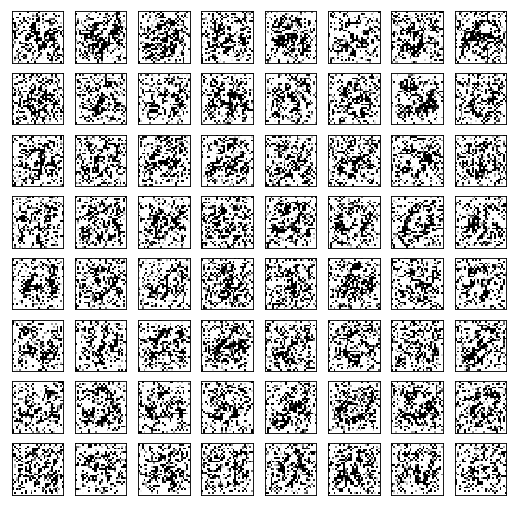

Iteration 482000: loss=0.0008139755809679627
Iteration 484000: loss=0.0008139752317219973
Iteration 486000: loss=0.0008139755227603018
Iteration 488000: loss=0.0008139746496453881
Iteration 490000: loss=0.0008139745914377272
Iteration 492000: loss=0.0008139738929457963
Iteration 494000: loss=0.0008139729616232216
Iteration 496000: loss=0.000813972728792578
Iteration 498000: loss=0.0008139722631312907
Iteration 500000: loss=0.0008139720885083079
Iteration 502000: loss=0.0008139719720929861
Iteration 504000: loss=0.0008139715064316988
Iteration 506000: loss=0.0008139712153933942
Iteration 508000: loss=0.0008139711571857333
Iteration 510000: loss=0.0008139709825627506
Iteration 512000: loss=0.0008139701676554978
Iteration 514000: loss=0.000813970051240176
Iteration 516000: loss=0.0008139695273712277
Iteration 518000: loss=0.000813969352748245
Iteration 520000: loss=0.000813968712463975


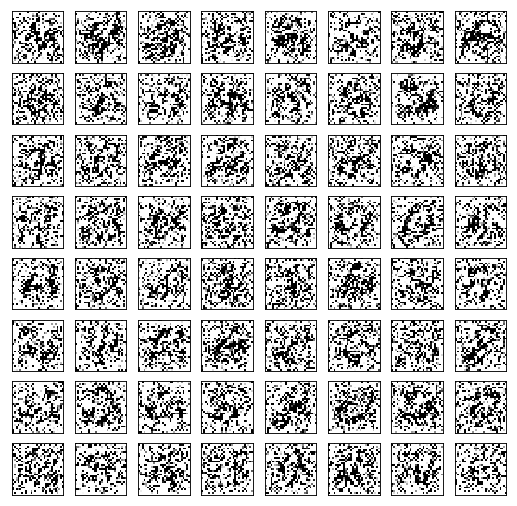

Iteration 522000: loss=0.0008139690617099404
Iteration 524000: loss=0.0008139683632180095
Iteration 526000: loss=0.0008139682468026876
Iteration 528000: loss=0.000813968013972044
Iteration 530000: loss=0.0008139675483107567
Iteration 532000: loss=0.0008139672572724521
Iteration 534000: loss=0.0008139667916111648
Iteration 536000: loss=0.0008139666169881821
Iteration 538000: loss=0.0008139665005728602
Iteration 540000: loss=0.0008139665005728602
Iteration 542000: loss=0.0008139660931192338
Iteration 544000: loss=0.0008139658020809293
Iteration 546000: loss=0.000813965336419642
Iteration 548000: loss=0.0008139649871736765
Iteration 550000: loss=0.0008139648707583547
Iteration 552000: loss=0.0008139646961353719
Iteration 554000: loss=0.0008139644050970674
Iteration 556000: loss=0.0008139638812281191
Iteration 558000: loss=0.0008139638230204582
Iteration 560000: loss=0.0008139637066051364


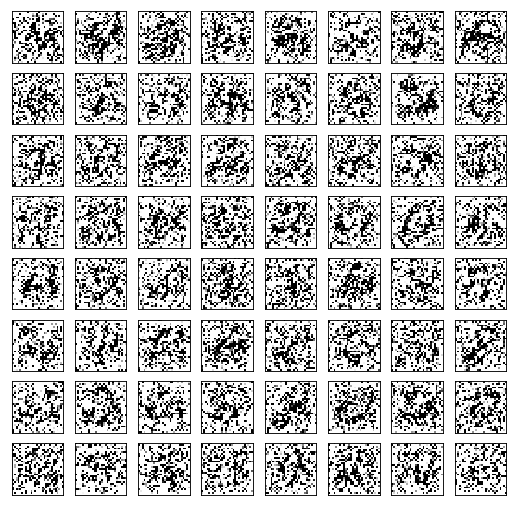

Iteration 562000: loss=0.0008139628916978836
Iteration 564000: loss=0.0008139625424519181
Iteration 566000: loss=0.0008139624260365963
Iteration 568000: loss=0.0008139618439599872
Iteration 570000: loss=0.0008139615529216826
Iteration 572000: loss=0.0008139614365063608
Iteration 574000: loss=0.0008139605051837862
Iteration 576000: loss=0.0008139598066918552
Iteration 578000: loss=0.0008139591664075851
Iteration 580000: loss=0.0008139571291394532
Iteration 582000: loss=0.0008139547426253557
Iteration 584000: loss=0.0008139538113027811
Iteration 586000: loss=0.0008139535202644765
Iteration 588000: loss=0.0008139530546031892
Iteration 590000: loss=0.0008139528217725456
Iteration 592000: loss=0.0008139526471495628
Iteration 594000: loss=0.0008139520650729537
Iteration 596000: loss=0.0008139520650729537
Iteration 598000: loss=0.0008139520068652928
Iteration 600000: loss=0.0008139514829963446


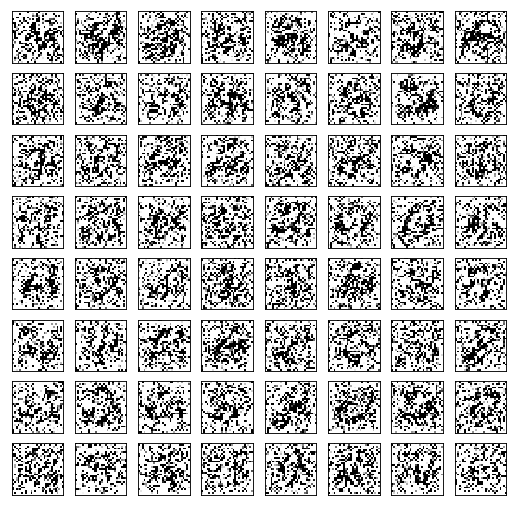

Iteration 602000: loss=0.0008139515412040055
Iteration 604000: loss=0.0008139511337503791
Iteration 606000: loss=0.0008139509591273963
Iteration 608000: loss=0.0008139506098814309
Iteration 610000: loss=0.0008139502024278045
Iteration 612000: loss=0.0008139501442201436
Iteration 614000: loss=0.000813949853181839
Iteration 616000: loss=0.000813949853181839
Iteration 618000: loss=0.0008139499113894999
Loss is rising .. stop


In [18]:
new_image_randn = generate_image(img)

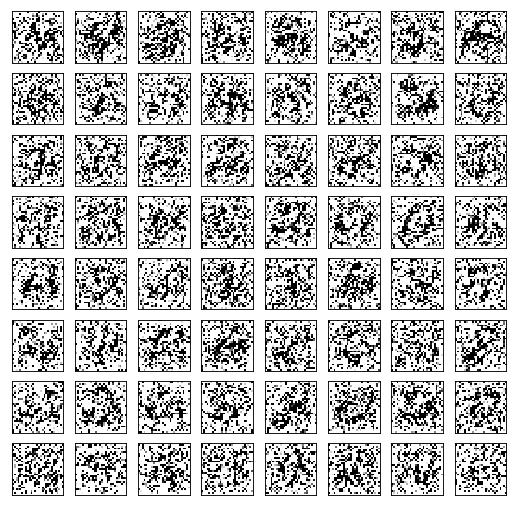

In [19]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [20]:
latent = model.E(new_image_randn.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 0.8536,  0.0079,  0.0091,  ...,  0.0016,  0.0278,  0.0178],
        [ 0.0073,  0.9349,  0.0210,  ...,  0.0044,  0.0038,  0.0006],
        [ 0.0023,  0.0406,  0.8975,  ...,  0.0022,  0.0013,  0.0008],
        ...,
        [ 0.0040,  0.0125,  0.0075,  ...,  0.8629,  0.0152,  0.0017],
        [ 0.0183,  0.0065,  0.0042,  ...,  0.0242,  0.8591,  0.0021],
        [ 0.0428,  0.0054,  0.0050,  ...,  0.0065,  0.0040,  0.8595]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


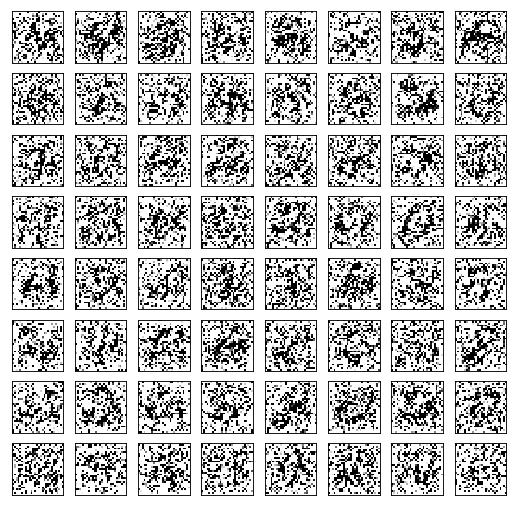

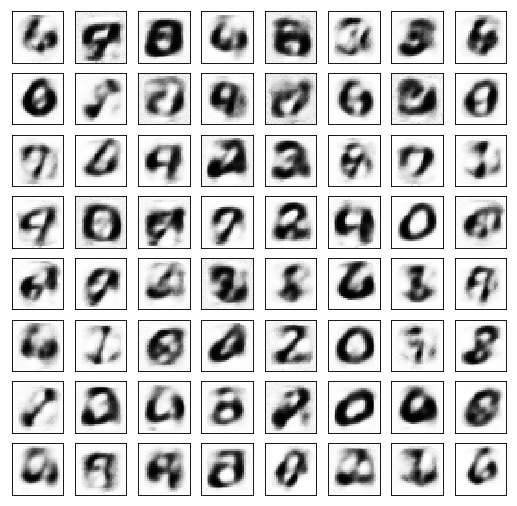

In [21]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_randn.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8)) 